<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/FER_with_CNN_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"

Cloning into 'EC523-Deep-Learning-Project'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 74 (delta 11), reused 6 (delta 1), pack-reused 40
Unpacking objects: 100% (74/74), done.


In [2]:
!pip install unrar

In [3]:
# !unrar x "EC523-Deep-Learning-Project/datasets/ckplus.rar"
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


##Imports

In [4]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [5]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

transform = transforms.Normalize(mean=129.4456, std = 1)

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [6]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample


# mu, st = 129.4456, 255
mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ]) 

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [7]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

Neutral Neutral    Fear    Fear Neutral


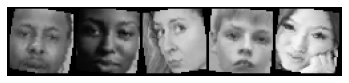

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

##Model

In [9]:
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.lin1 = nn.Linear(256*6*6, 4096) # Will have to change input size
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)
        
        #self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        # print("shape before linear layers!!: ", x.shape)

        x = x.view(-1, 256*6*6) # will have to change!
        # print("reshaped", x.shape)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

In [10]:
class Subnet2(nn.Module):
    def __init__(self):
        super(Subnet2, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        #self.drop = nn.Dropout(0.2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)
        #print("shape before linear layers!!: ", x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

In [11]:
class Subnet3(nn.Module):
    def __init__(self):
        super(Subnet3, self).__init__()
        # Not sure about number of in channels, may have to change!

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        x = x.view(-1, 256*6*6) # CHANGE
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

##Training

In [20]:
net = Subnet3()
net = net.to(device)

In [21]:
def train_model(net, trainloader, valloader, n_epochs=20):

    acc_train_arr, acc_val_arr = [], []
    loss_train_arr, loss_val_arr = [], []
    for epoch in range(n_epochs):
        
        net = net.train()
        loss_train, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_train += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_train = 100 * correct_count / n
        loss_train = loss_train / n

        acc_val, loss_val = test_model(net, valloader)

        loss_train_arr.append(loss_train)
        loss_val_arr.append(loss_val)
        
        acc_train_arr.append(acc_train)
        acc_val_arr.append(acc_val)
        
        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_train), 'Val Accuracy: %2.2f %%' % (acc_val), sep='\t\t')

    return loss_train_arr, loss_val_arr, acc_train_arr, acc_val_arr

In [22]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [24]:
loss_train, loss_val, acc_train, acc_val = train_model(net, trainloader, valloader, n_epochs=100)

Epoch  1		Train Accuracy: 25.01 %		Val Accuracy: 24.49 %
Epoch  2		Train Accuracy: 25.12 %		Val Accuracy: 24.99 %
Epoch  3		Train Accuracy: 27.69 %		Val Accuracy: 29.87 %
Epoch  4		Train Accuracy: 30.94 %		Val Accuracy: 33.30 %
Epoch  5		Train Accuracy: 34.61 %		Val Accuracy: 38.92 %
Epoch  6		Train Accuracy: 38.42 %		Val Accuracy: 40.79 %
Epoch  7		Train Accuracy: 40.89 %		Val Accuracy: 41.40 %
Epoch  8		Train Accuracy: 41.97 %		Val Accuracy: 44.27 %
Epoch  9		Train Accuracy: 44.33 %		Val Accuracy: 44.30 %
Epoch 10		Train Accuracy: 45.81 %		Val Accuracy: 46.42 %
Epoch 11		Train Accuracy: 47.66 %		Val Accuracy: 48.45 %
Epoch 12		Train Accuracy: 49.41 %		Val Accuracy: 51.02 %
Epoch 13		Train Accuracy: 50.76 %		Val Accuracy: 53.41 %
Epoch 14		Train Accuracy: 52.40 %		Val Accuracy: 49.71 %
Epoch 15		Train Accuracy: 53.78 %		Val Accuracy: 54.36 %
Epoch 16		Train Accuracy: 55.26 %		Val Accuracy: 56.81 %
Epoch 17		Train Accuracy: 56.55 %		Val Accuracy: 55.48 %
Epoch 18		Train Accuracy: 57.90

##Evaluation

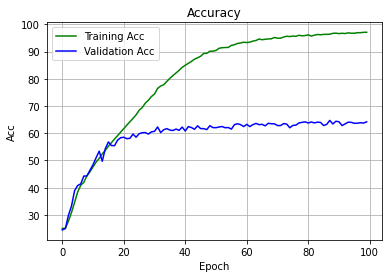

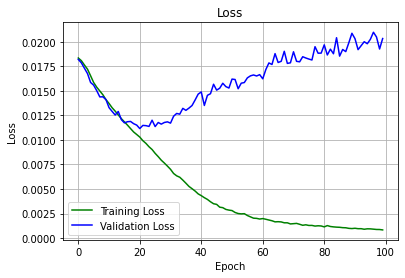

Test Accuracy: 63.22 %
Average Test Loss: 0.0217 %


In [25]:
plt.figure()
plt.plot(acc_train, 'g', label='Training Acc')
plt.plot(acc_val, 'b', label='Validation Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(loss_train, 'g', label='Training Loss')
plt.plot(loss_val, 'b', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

acc, loss = test_model(net, testloader)
print('Test Accuracy: %2.2f %%' % (acc))
print('Average Test Loss: %2.4f %%' % (loss))

##Save Model

In [26]:
path = 'subnet3'
torch.save(net.state_dict(), path)

In [27]:
from google.colab import files
files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>